In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import coffea.hist as hist
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams.update({'font.size': 16})
import scipy
import math
import numba
import bitstruct as bitstruct

In [38]:
def getDataRaw(fname):
    data = []
    format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(256*int(30/5))
    with open(fname, "rb") as f:
        line = f.read((1+4+int(256*30/5))*8)
        while len(line) == (1+4+int(256*30/5))*8:
            data.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
            line = f.read((1+4+int(256*30/5))*8)
    data = np.array(data)
    return data.reshape([-1, 30, 256])

def getData(fnames):
    data = []
    for fname in fnames:
        with open(fname) as f:
            for line in f:
                data.extend(line.split()[1:31])
    data = np.array(data, dtype='float')
    return data.reshape([-1, 256, 30])    

In [39]:
ped_data = getDataRaw("testData/cal_0812_2.txt")
data = getDataRaw("testData/sinRand_4.txt")#getData(["Data_20200312_030712.txt",])
sineData = data
true_freq = 48636899.0*5
#sineData = getData(["Data_20200312_034047.txt", "Data_20200312_034055.txt"])

In [40]:
#averages = np.zeros(ped_data.mean(0).shape)
averages = ped_data.mean(0)
stddevs = ped_data.std(0)
#averages = averages.transpose()

In [41]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B
def wrap(x):
    return np.fmod(np.fmod(x, 2*math.pi)+math.pi, 2*math.pi)-math.pi

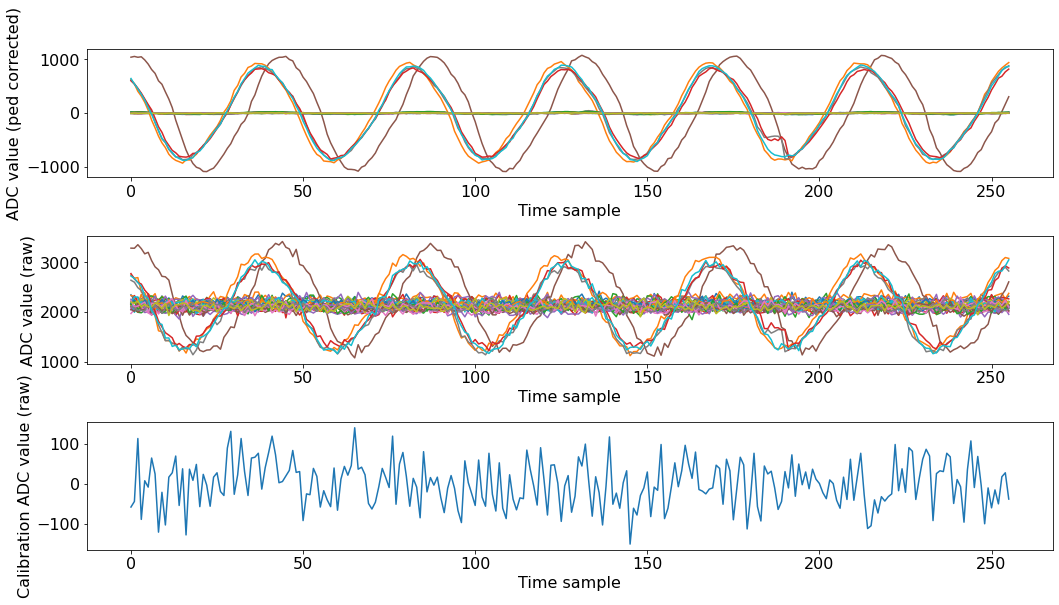

In [310]:
   
#channel_pulse = np.array([5,11,17,23,29])
#channel_pulse = np.array([3,24,])
#channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
event = 20

xdata = np.linspace(0, 255,256)
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:]


#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/5, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:200], ydata[0:200], p0=popt)
#print(*popt)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

#plt.plot(data[1,channel,2:]-data[1,channel,2:].mean())
#plt.plot(xdata, ydata_raw, label="data")
#ax1.plot(xdata, ydata, label="250 MHz sine")
#ax1.plot(xdata, sine(xdata, *popt), label="sine fit")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="Pulse %i"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

#ax2.plot(xdata, ydata_raw, label="250 MHz sine")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

for i, d in enumerate(ydata_pulse_cal):
    ax3.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax3.set_xlabel("Time sample")
ax3.set_ylabel("Calibration ADC value (raw)")

fig.tight_layout()



Text(0.5, 0, 'trigger_pos')

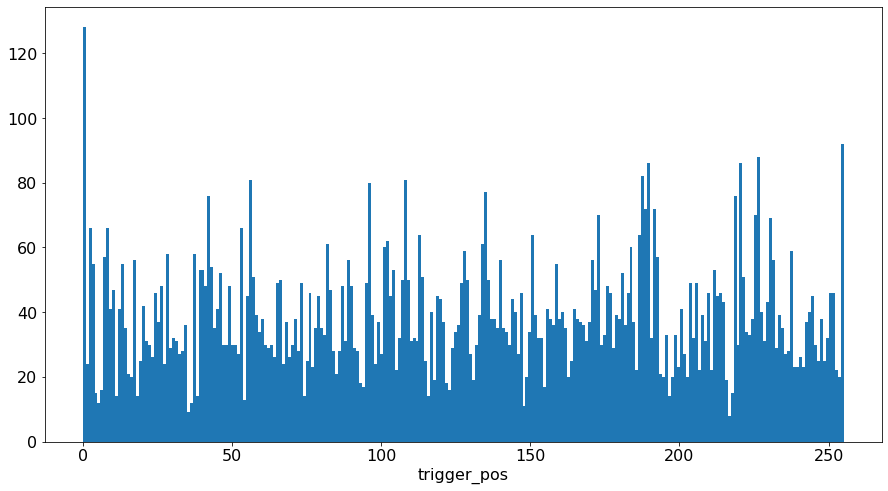

In [17]:
trigger_pos = [0]*10000

for e in range(0,10000):
    pulse = sineData[e,:,:]-averages[:,:]
    max = 0
    for iCap in range(256):
            cap0 = (iCap+255)%256
            cap1 = iCap
            cap2 = (iCap+1)%256
            diff01 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[11, cap1]+pulse[11, cap0])
            diff02 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[17, cap1]+pulse[17, cap0])
            diff03 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[23, cap1]+pulse[23, cap0])
            diff04 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[29, cap1]+pulse[29, cap0])
            diff11 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[11, cap2]+pulse[11, cap1])
            diff12 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[17, cap2]+pulse[17, cap1])
            diff13 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[23, cap2]+pulse[23, cap1])
            diff14 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[29, cap2]+pulse[29, cap1])
            diffsum  = diff01+diff02+diff03+diff04+diff11+diff12+diff13+diff14
            if max <diffsum:
                max = diffsum
                trigger_pos[e] = cap1 
plt.hist(trigger_pos, 256)
plt.xlabel("trigger_pos")

In [7]:
means = []
x_vals = [i for i in range(0x10, 0xfff, 0x10)]
for i in x_vals:
    if i % 0x100 == 0: print(i)
    pedData = getDataRaw("configs/0/scan_pedestals_%i"%i)
    means.append(pedData.mean(0))
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

channel = 3

for i in range(256):
    meanList = np.array([mean[channel,i] for mean in means])
    plt.plot(refVoltage, meanList)
    
plt.xlabel("reference voltage (V)")
plt.ylabel("measured ADC")

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840


In [10]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [19]:
import scipy.interpolate
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

def lineraize_wrap(f, val):
    try:
        return f(val)
    except(ValueError):
        if val < 2000:
            return 0
        else:
            return 3.3

vlineraize_wrap = np.vectorize(lineraize_wrap)
        
voltageLin = []
for j in range(0, 30):
    voltageLin.append([])
    for i in range(0, 256):
        meanList = np.array([mean[j,i] for mean in means])
        meanList = savitzky_golay(meanList, 41, 2)
        voltageLin[j].append(scipy.interpolate.interp1d(meanList, refVoltage))
        
xv = np.array([acd for acd in range(4096)])
yv = vlineraize_wrap(voltageLin[0][0], xv)

linDat = np.zeros_like(sineData, float)
for j in range(0, 30):
    for i in range(0, 256):
        linDat[:,j,i] = lineraize_wrap(voltageLin[j][i], sineData[:,j,i])

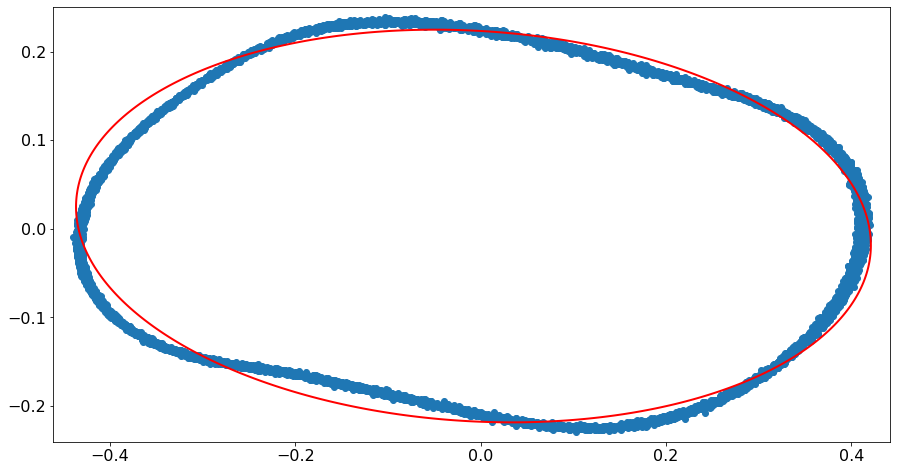

In [27]:
#ydata = sineData-averages
ydata = linDat - 1.2/4096*0x800

timeOffsets = np.zeros((30, 256))
for channel in [11, 17, 23, 29]:
    chTimeOffsets = []
    x = []
    y =[]
    for iCap in range(256):
        
        cap1 = iCap
        cap2 = (iCap+1)%256
        r = []
        for e in range(0,10000):
            if abs(trigger_pos[e]-cap1)<15 or (trigger_pos[e]-15<0 and 256-cap1+trigger_pos[e]<15) or (cap1-15<0 and 256-trigger_pos[e]+cap1<15):
                continue
            else: 
                r.append(e)


        x.append(ydata[r,channel, cap2] + ydata[r,channel, cap1])
        y.append(ydata[r,channel, cap1] - ydata[r,channel, cap2])

        #y = y[(x > 1200) | (x < -1200)]
        #x = x[(x > 1200) | (x < -1200)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
        b = np.ones_like(x[iCap])
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        try:
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*true_freq)
            #print("dtij = %f ps"%(dtij*1e12))
            chTimeOffsets.append(dtij)
        except:
            chTimeOffsets.append(100.0e-12)
    timeOffsets[channel] = np.array(chTimeOffsets)


#plt.plot(ydata[0,:,5])
sample = 255
plt.scatter(x[sample], y[sample])

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x[sample].min(),1.05*x[sample].max(),300)
y_coord = np.linspace(1.05*y[sample].min(),1.05*y[sample].max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

Text(0.5, 0, 'time offsets (ps)')

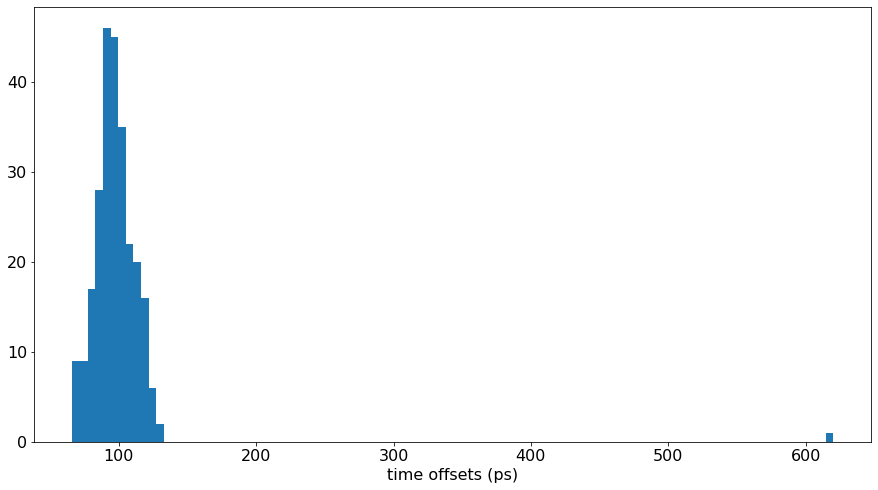

In [28]:
plt.hist(timeOffsets[29]*1e12, 100)
plt.xlabel("time offsets (ps)")

Text(0.5, 0, 'timesample')

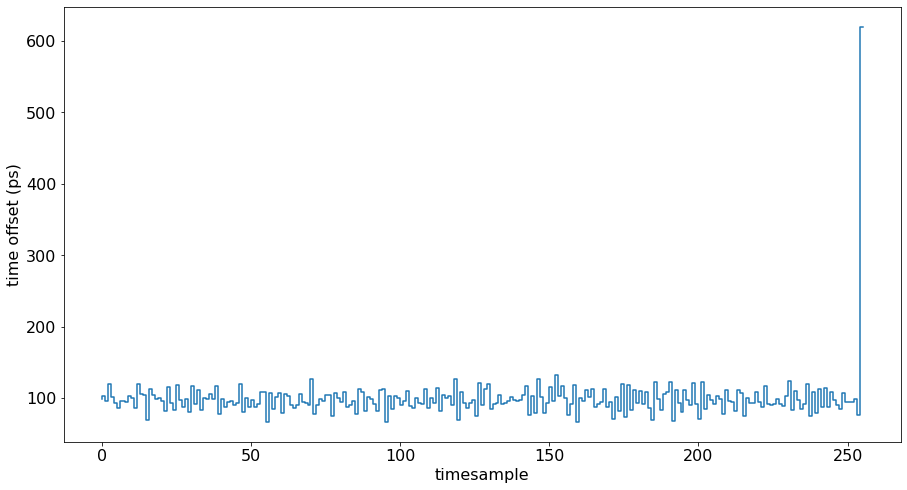

In [35]:
plt.step(np.linspace(0, 255, 256), timeOffsets[29]*1e12)
plt.ylabel("time offset (ps)")
plt.xlabel("timesample")

In [ ]:
plt.step(np.linspace(0, 255, 256), timeOffsets[29]*1e12)
plt.ylabel("time offset (ps)")
plt.xlabel("timesample")

0.70537521876794 0.03907925869442077 1570997526.1660066 144.78334959035158


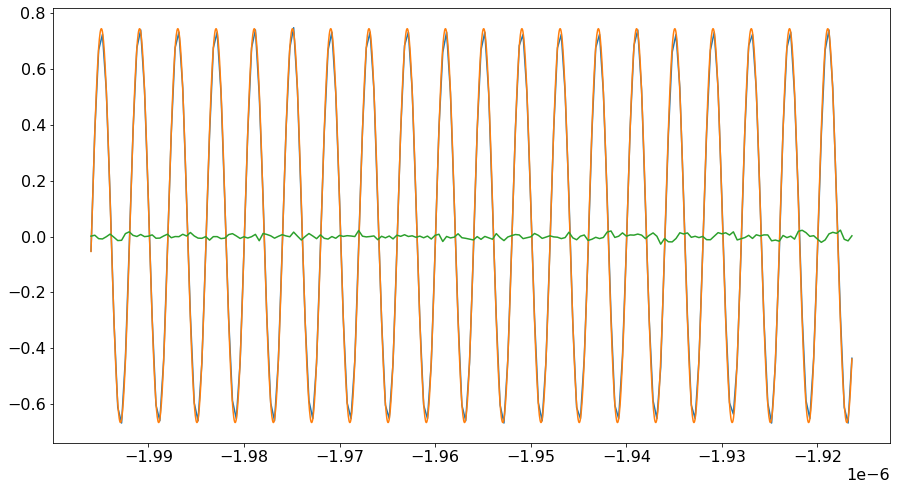

In [ ]:
x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)

popt=(0.75, 0.0, 1.50/1e-9, 0.0)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[50:60], y_tsdata[50:60], p0=popt)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[0:100], y_tsdata[0:100], p0=popt)
print(*popt)

diff = y_tsdata - sine(x_tsdata, *popt)

plt.plot(x_tsdata[:200], y_tsdata[:200])

x_sim = np.linspace(x_tsdata[:200].min(), x_tsdata[:200].max(), 2000)
plt.plot(x_sim, sine(x_sim, *popt), label="sine fit")

plt.plot(x_tsdata[:200], diff[:200])

902.2631716750004 3.592298062120782 0.14408683129245053 -5.871691599513418
mse: 0.650075


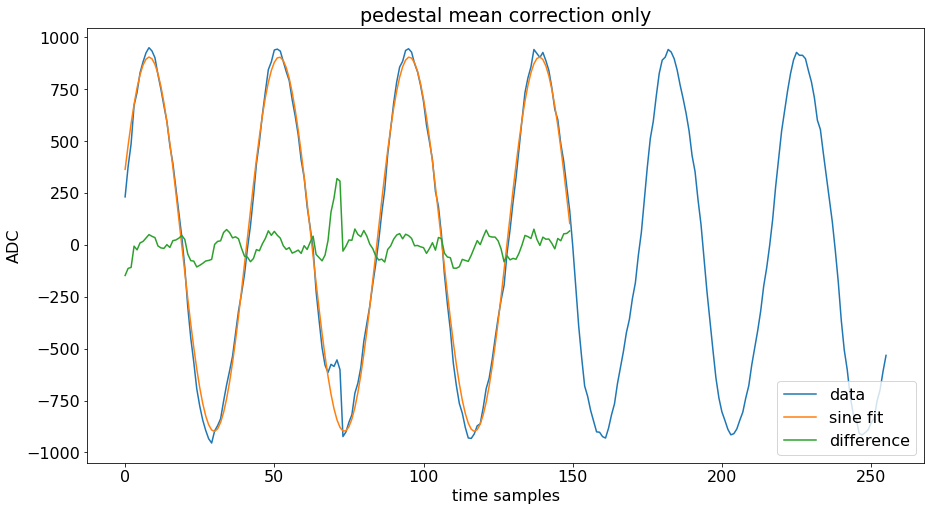

In [218]:
from scipy import optimize
event = 5
channel = 11

xdata = np.linspace(0, 255,256)
ydata = sineData[event,channel,:]-averages[channel, :]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:150], ydata[:150], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
pmco_diff = diff
print("mse: %f"%((diff**2)[:150].sum()))

plt.title("pedestal mean correction only")
plt.xlabel("time samples")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata[:150], sine(xdata[:150], *popt), label="sine fit")

plt.plot(xdata[:150], diff[:150]*1000, label="difference")

plt.legend(loc="lower right")

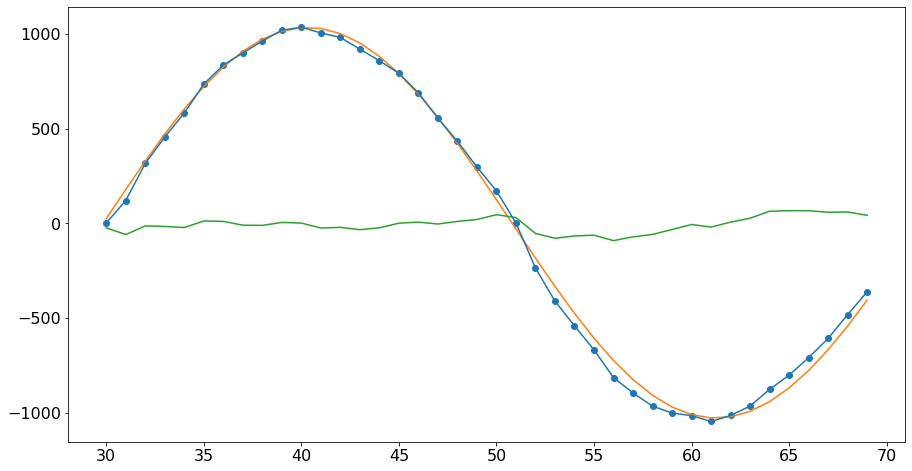

In [ ]:
plt.scatter(xdata[30:70], ydata[30:70], label="data")
plt.errorbar(xdata[30:70], ydata[30:70], yerr=3, label="data")

plt.plot(xdata[30:70], sine(xdata[30:70], *popt), label="sine fit")

plt.plot(xdata[30:70], diff[30:70]*popt[0], label="difference")

In [165]:
xdata = np.linspace(0, 255,256)
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
vlo_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Voltage linearization only")
plt.xlabel("time samples")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

NameError: name 'linDat' is not defined

865.670238869239 -7.572048545938256 1.4863520874328442 0.17040814445800195
mse: 0.513777


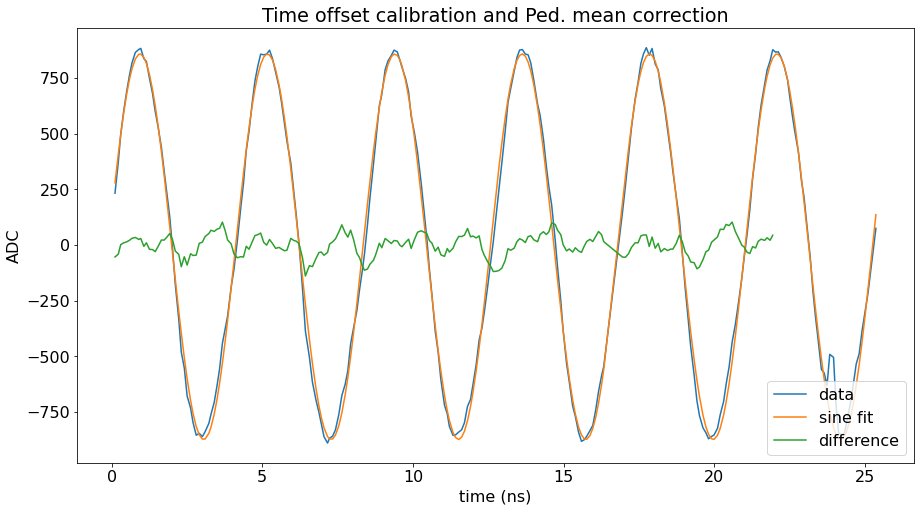

In [49]:
event = 5
channel = 29
ringTimeOffsets = np.concatenate((timeOffsets,timeOffsets,timeOffsets), 1)
xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
ydata = sineData[event,channel,:]-averages[channel, :]
ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -400),(2000, 2000, true_freq*math.pi*2e-9*1.2,400)))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)

print(*popt)

diff = (ringydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:220].sum()))

plt.title("Time offset calibration and Ped. mean correction")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ringydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:220], diff[:220]*1000, label="difference")

plt.legend(loc="lower right")

-0.23927754802618814 0.5950847190295432 1.48777167396399 0.46192105132313827
mse: 0.494389


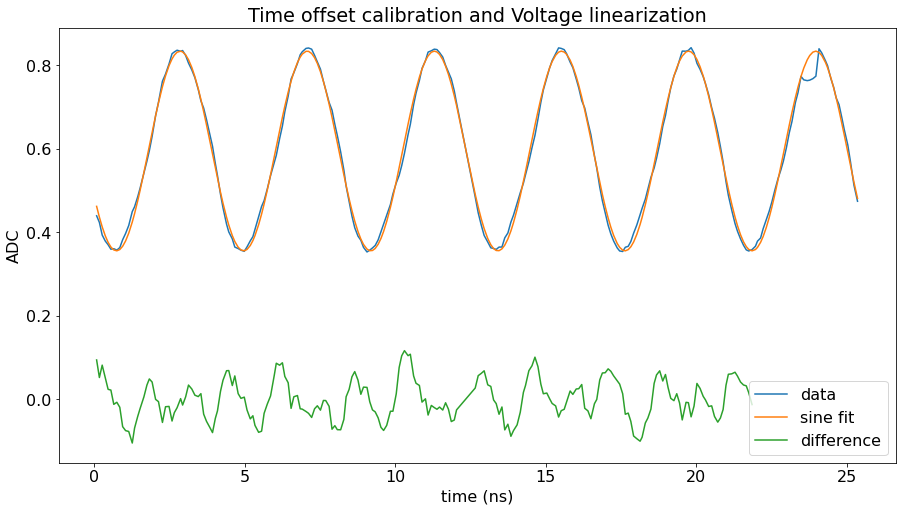

In [47]:
event = 7
channel = 29
import scipy.optimize
ringTimeOffsets = np.concatenate((timeOffsets,timeOffsets,timeOffsets), 1)
xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
ydata = linDat[event, channel, :]
ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -400),(2000, 2000, true_freq*math.pi*2e-9*1.2,400)))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)

print(*popt)

diff = (ringydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:220].sum()))

plt.title("Time offset calibration and Voltage linearization")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ringydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:220], diff[:220], label="difference")

plt.legend(loc="lower right")

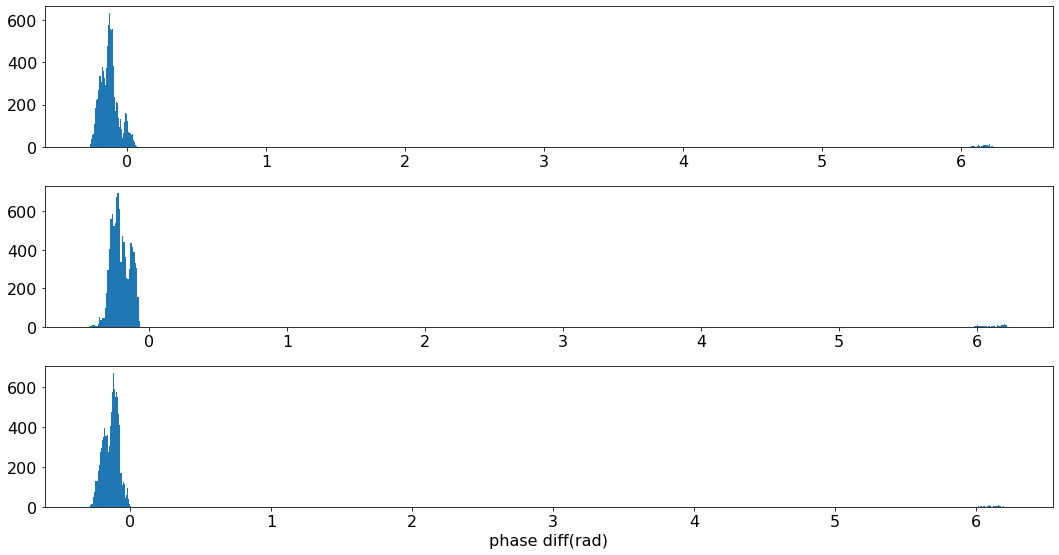

In [317]:
phase = np.zeros((10000, 30))
for event in range(10000):
    for channel in [11, 17, 23,29]:
        xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
        ydata = sineData[event,channel,:]-averages[channel, :]
        ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
        #ydata = linDat[event, :, 5]

        popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -4),(2000, 2000, true_freq*math.pi*2e-9*1.2,4)))
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)
        phase[event, channel] = popt[3]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.hist(wrap(phase[:,17] - phase[:,11]), bins="fd")
ax2.hist(wrap(phase[:,23] - phase[:,11]), bins="fd")
ax3.hist(wrap(phase[:,29] - phase[:,11]), bins="fd")#/true_freq/math.pi/2e-9
plt.xlabel("phase diff(rad)")
fig.tight_layout()
    

0.30721129658631996 0.5994629531264452 1.5745048426530697 -11.001931054749994
mse: 0.348352


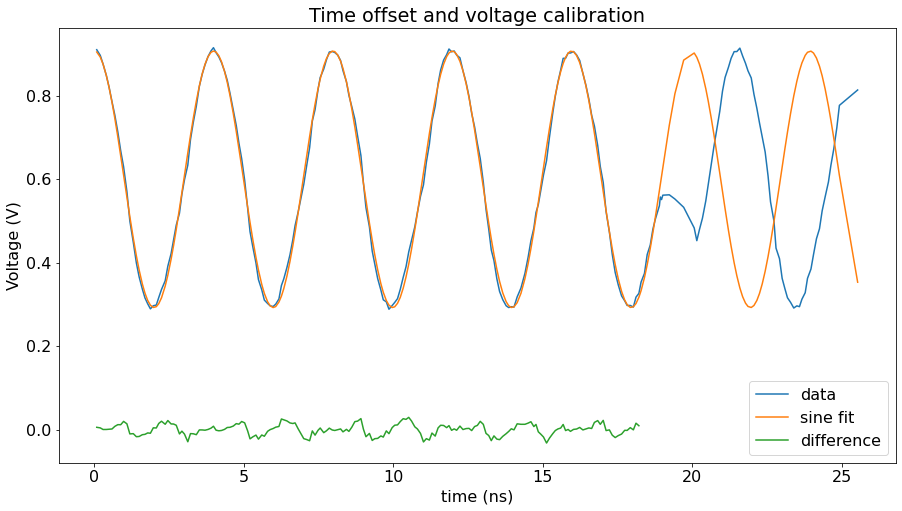

In [ ]:

#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, channel, :]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/5000, 0.6))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/np.abs(popt[0])
all_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset and voltage calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

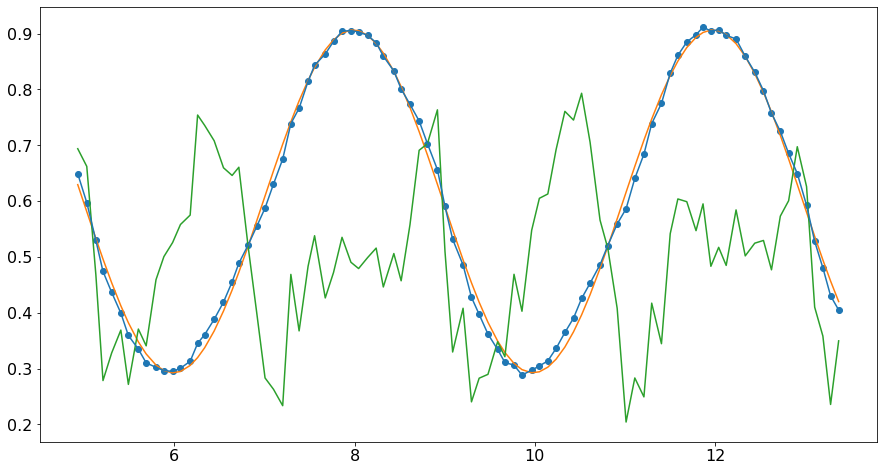

In [ ]:
t = 20
s = slice(30+t,120+t)

plt.scatter(xdata[s], ydata[s], label="data")
plt.errorbar(xdata[s], ydata[s], yerr=3*1.2/4096, label="data")

plt.plot(xdata[s], sine(xdata[s], *popt), label="sine fit")

plt.plot(xdata[s], diff[s]*popt[0]*10 + 0.5, label="difference")

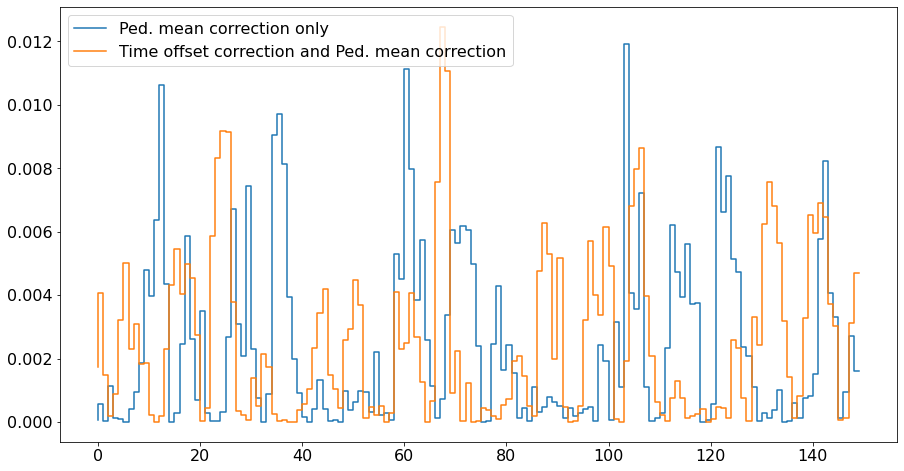

In [202]:
xdat = np.linspace(0, 149, 150)
plt.step(xdat,pmco_diff[:150]**2, label="Ped. mean correction only")
#plt.step(xdat,vlo_diff[:190]**2, label="Voltage linearization only")
plt.step(xdat,toco_diff[:150]**2, label="Time offset correction and Ped. mean correction")
#plt.step(xdat,all_diff[:190]**2, label="All corrections")
plt.legend()